# Classifying Google Voice Commands Using CNN

### Model Training and Evaluation 

### Load Preprocessed data 

In [1]:
# Retrieve the preprocessed data from the files you created in the last notebook 
# (Please complete the previous notebook first!!)
import os
import numpy as np
from random import shuffle

np.random.seed(1)
# SET THIS TO THE DIRECTORY WHERE YOU CREATED THE PREPROCESSED FILES IN THE LAST NOTEBOOK !
preprocessed_dir = '../Preproc'
dir_name = '../googleData'
train_path = os.path.join(preprocessed_dir, 'train')
test_path = os.path.join(preprocessed_dir, 'test')
class_names = sorted(os.listdir(train_path))

Now lets make a function for loading all our preprocessed data.

In [2]:
def load_data(data_dir):
    class_names = sorted(os.listdir(data_dir))
    nb_classes = len(class_names)
    print("class_names = ",class_names)

    for (dirpath, dirnames, filenames) in os.walk(os.path.join(data_dir, class_names[0])):
        with np.load(os.path.join(data_dir, class_names[0], filenames[0])) as sample_file:
            mel_dims = sample_file['melgram'].shape

    total_load = 0
    for classname in class_names:
        files = os.listdir(os.path.join(data_dir, classname))
        n_files = len(files)
        total_load += n_files

    X = np.zeros((total_load, mel_dims[1], mel_dims[2], mel_dims[3]))
    Y = np.zeros((total_load, nb_classes))
    paths = []

    load_count = 0
    num_classes = len(class_names)
    label_smoothing = 0.005

    for idx, classname in enumerate(class_names):
        # Vector smoothing means that some allowance is made for classes where the the files 
        idx = class_names.index(classname)
        vec = np.zeros(num_classes)
        vec[idx] = 1
        vec = vec * (1 - label_smoothing) + label_smoothing / num_classes

        this_Y = np.array(vec)
        this_Y = this_Y[np.newaxis,:]
        file_list = os.listdir(os.path.join(data_dir, classname))
        shuffle(file_list)  # just to remove any special ordering

        for _, infilename in enumerate(file_list): 
            audio_path = os.path.join(data_dir, classname, infilename)
            with np.load(audio_path) as data:
                melgram = data['melgram']
            if melgram.shape != mel_dims:
                raise Exception('Dimension mismatch {} vs {}'.format(melgram.shape, mel_dims))

            X[load_count,:,:] = melgram[:,:,:]
            Y[load_count,:] = this_Y
            paths.append(audio_path)
            load_count += 1
        print('Successfully processed {} files for class {}'
              .format(len(file_list), classname))



    assert (X.shape[0] == Y.shape[0] )
    # Shuffle the classes up 
    idx = np.array(range(Y.shape[0]))
    np.random.shuffle(idx)
    newX = np.copy(X)
    newY = np.copy(Y)
    for i in range(len(idx)):
        newX[i] = X[idx[i],:,:]
        newY[i] = Y[idx[i],:]

    return newX, newY

Next let's load both the training and test data.

In [3]:

X_train, Y_train = load_data(train_path)
X_test, Y_test = load_data(test_path)

class_names =  ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
Successfully processed 1456 files for class bed
Successfully processed 1471 files for class bird
Successfully processed 1473 files for class cat
Successfully processed 1484 files for class dog
Successfully processed 2005 files for class down
Successfully processed 1999 files for class eight
Successfully processed 2003 files for class five
Successfully processed 2016 files for class four
Successfully processed 2016 files for class go
Successfully processed 1480 files for class happy
Successfully processed 1487 files for class house
Successfully processed 2000 files for class left
Successfully processed 1484 files for class marvin
Successfully processed 2009 files for class nine
Successfully processed 2018 files for class no
Successfully proce

### Initial model architecture - CNN

#### Describe archtecture here !!

In [4]:
from keras import backend as K
from keras.models import Sequential,  load_model, save_model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Conv2D
from keras.layers.normalization import BatchNormalization

nb_layers=4
K.set_image_data_format('channels_last')                   
nb_filters = 32  # number of convolutional filters
kernel_size = (3, 3)  # convolution kernel size
pool_size = (2, 2)  # size of pooling area for max pooling
cl_dropout = 0.5    # conv. layer 
dl_dropout = 0.6    # dense layer 
X_shape = X_train.shape

print(" CNN: X_shape = ",X_shape,", channels = ",X_shape[3])
input_shape = (X_shape[1], X_shape[2], X_shape[3])
model = Sequential()
model.add(Conv2D(nb_filters, kernel_size, padding='same', input_shape=input_shape, name="Input"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Activation('relu'))      
model.add(BatchNormalization(axis=-1)) 

for layer in range(nb_layers-1):   
    model.add(Conv2D(nb_filters, kernel_size, padding='same'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Activation('elu'))
    model.add(Dropout(cl_dropout))

model.add(Flatten())
model.add(Dense(128))  
model.add(Activation('elu'))
model.add(Dropout(dl_dropout))
model.add(Dense(len(class_names)))
model.add(Activation("softmax",name="Output"))



Using TensorFlow backend.


 CNN: X_shape =  (55001, 96, 87, 1) , channels =  1


### Compiling the model 

Next compile the model


In [5]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Conv2D)               (None, 96, 87, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 43, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 48, 43, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 43, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 43, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 21, 32)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 24, 21, 32)       

## Get diagram

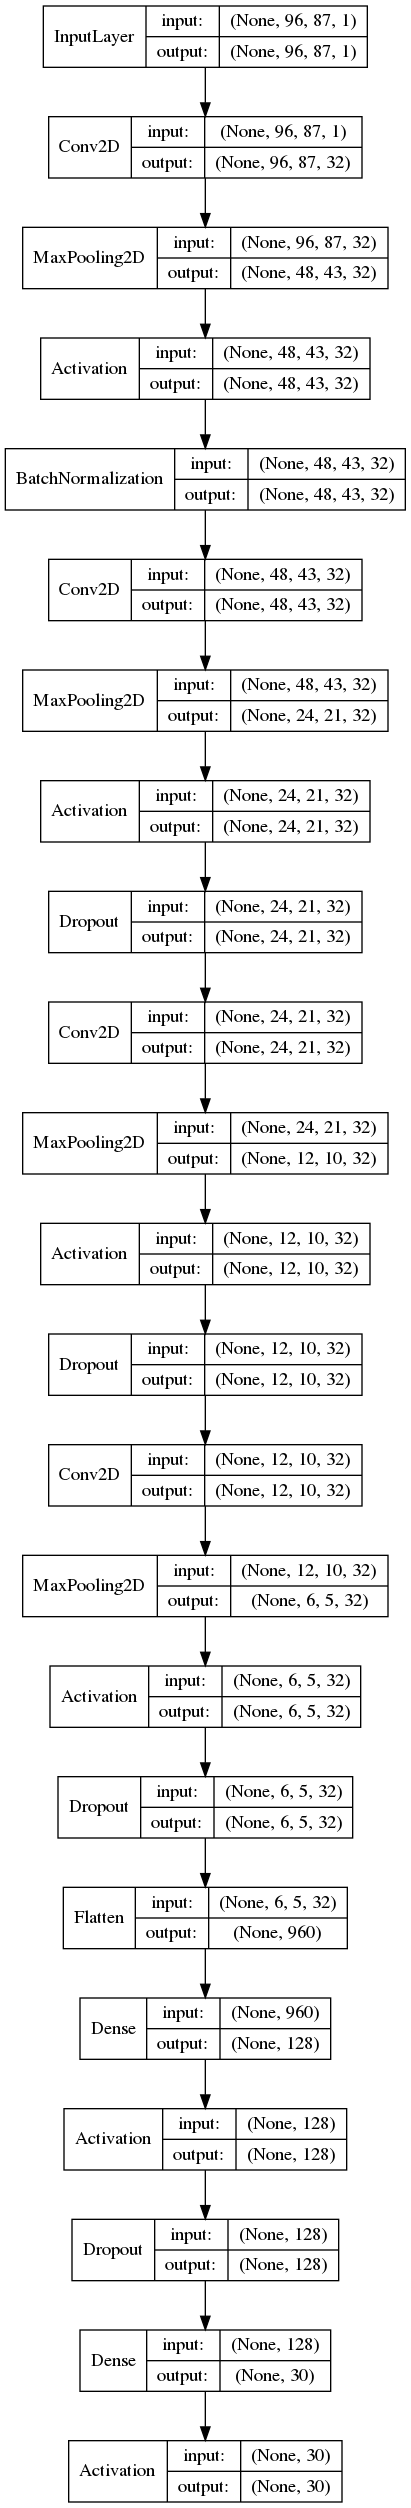

In [10]:
from keras.utils import plot_model
import numpy as np
from IPython.display import SVG
from keras.utils import model_to_dot

plot_model(model, show_shapes=True, show_layer_names=False)

#### Training the model
Here let's train the model. Since the train/test split was set by default to .85/.15; here setting the train/val split to .8/.2 results in a train/val/test split of roughly .7/.15/.15

In [6]:
from keras.callbacks import ModelCheckpoint 
from keras.models import load_model

# Display model architecture summary 
val_split = 0.2
epochs = 100 # 100 (but since I have already trained the weights file I don't need to retrain.)
# In order to retrain from scratch please delete the weights file and set the epochs to between 20 - 100
batch_size = 32

split_index = int(X_train.shape[0]*(1-val_split))
X_val_data, Y_val_data = X_train[split_index:], Y_train[split_index:]
X_train_data, Y_train_data = X_train[:split_index-1], Y_train[:split_index-1]
weights_file='weights.hdf5'

if os.path.isfile(weights_file):
    loaded_model = load_model(weights_file) 
    model.set_weights( loaded_model.get_weights() )  
    print('Loading Weights from file {}'.format(weights_file))

checkpointer = ModelCheckpoint(filepath=weights_file, 
                               verbose=1, save_best_only=True)

model.fit(X_train_data, Y_train_data, batch_size=batch_size, epochs=epochs, shuffle=True,  callbacks=[checkpointer],
              verbose=1, validation_data=(X_val_data, Y_val_data))



Loading Weights from file weights.hdf5


### Test the model 

Here we will review the accuracy of the model on both the training and test data sets (here the training data is a compination of both the Train + Val sets). 

In [7]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9081653356552124
Testing Accuracy:  0.8955761194229126


Both training and test scores are quite high, suggesting the model has not overfit as there is little difference between the training and test models

## Confusion matrix
Lets build a confusion matrix of results

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Original source: scikit-learn documentation
    """
    plt.figure(figsize=(22,12))
    plt.subplot(1,2,1)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = title+" (normalized) \n"
    else:
        title = title+"\n"

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


9720/9720 [==============================] - 9s 890us/step


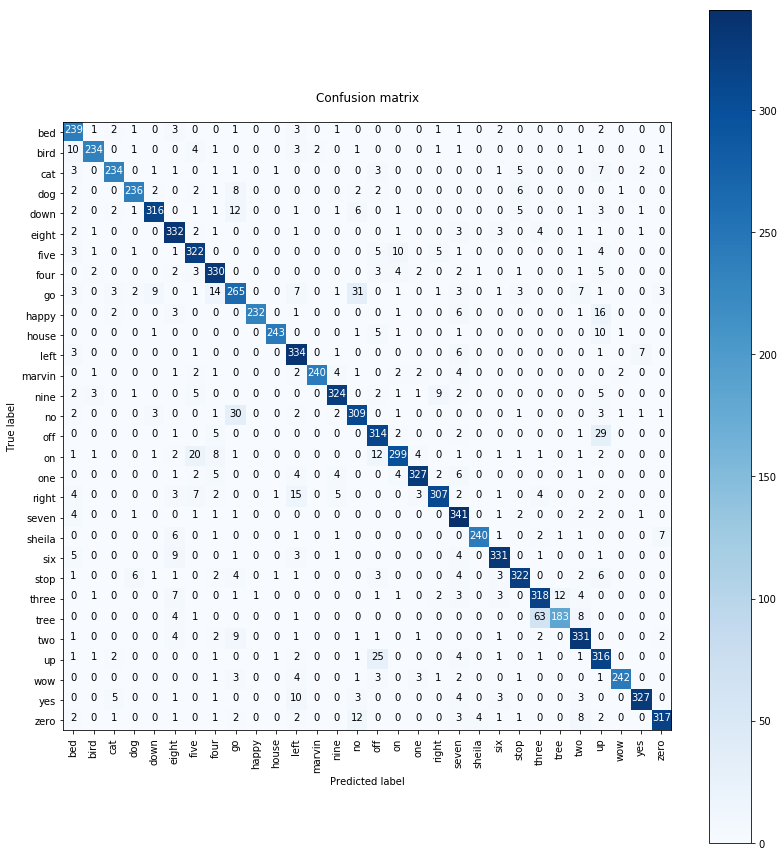

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as skmetrics
Y_pred = model.predict_classes(X_test, verbose=1)
Y_truth = np.argmax(Y_test, axis=1)


plot_confusion_matrix(skmetrics.confusion_matrix(y_true=Y_truth, y_pred=Y_pred), class_names)



In [11]:
print(Y_pred,  np.argmax(Y_test, axis=1)) 

[15 11 20 ... 27 22  3] [16 11 20 ... 27 22  3]


### Predictions  

Lets look closer as to what the model predicts, first set the labels

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
y = np.array(class_names)

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

Make a function for creating mel spectrograms from wav files

In [9]:
import librosa 
import numpy as np 

def extract_melgram(file_name):
    signal, sr = librosa.load(file_name, mono=False, sr=44100)
    if len(signal.shape) == 1:
        signal = np.reshape(signal, (1, signal.shape[0]))
    
    # Make sure all files have the same amount of data by padding empty space with 0
    shape = signal.shape
    max_shape = (1, sr) # Sample Rate is max_shape
    padded_signal = np.zeros(max_shape)     
    use_shape = list(max_shape[:])
    use_shape[0] = min( shape[0], max_shape[0] )
    use_shape[1] = min( shape[1], max_shape[1] )

    padded_signal[:use_shape[0], :use_shape[1]] = signal[:use_shape[0], :use_shape[1]]
    melgram = librosa.amplitude_to_db(librosa.feature.melspectrogram(padded_signal[0], sr=sr, n_mels=96))[np.newaxis,:,:,np.newaxis] 
    melgram = melgram.astype(np.float16)
    return  melgram


Make a function for predicting output from these wab files

In [10]:
def print_prediction(file_name):
    prediction_feature = extract_melgram(file_name) 

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

### Data exploration 

Now lets use these functions to examine presictions from the test dataset more closely

In [11]:
filename = os.path.join(dir_name, 'no/692a88e6_nohash_3.wav')
print_prediction(filename) 

bed 		 :  0.00005253347990219481289386749268
bird 		 :  0.00001033396347338566556572914124
cat 		 :  0.00097990257199853658676147460938
dog 		 :  0.00179204682353883981704711914062
down 		 :  0.04893958196043968200683593750000
eight 		 :  0.00000632218461760203354060649872
five 		 :  0.00000029669809009646996855735779
four 		 :  0.00005753804725827649235725402832
go 		 :  0.05414555966854095458984375000000
happy 		 :  0.00000810750862001441419124603271
house 		 :  0.00033942901063710451126098632812
left 		 :  0.00110550620593130588531494140625
marvin 		 :  0.00006271145684877410531044006348
nine 		 :  0.00122681527864187955856323242188
no 		 :  0.80255246162414550781250000000000
off 		 :  0.00001262950354430358856916427612
on 		 :  0.00000056981002671818714588880539
one 		 :  0.00013598210352938622236251831055
right 		 :  0.00002105480416503269225358963013
seven 		 :  0.00000228422982218035031110048294
sheila 		 :  0.00021371454931795597076416015625
six 		 :  0.000000280940270158680505

In [12]:
filename = os.path.join(dir_name, 'right/3411cf4b_nohash_0.wav')
print_prediction(filename) 

bed 		 :  0.00000000015882060944161224824711
bird 		 :  0.00000000001743351123184577744496
cat 		 :  0.00000000000219354352390399576223
dog 		 :  0.00000000000532284589668807761598
down 		 :  0.00000000000156870772882039544172
eight 		 :  0.00000001710475672211941855493933
five 		 :  0.00000000876910988267809443641454
four 		 :  0.00000000000338283893085156162073
go 		 :  0.00000000001498946279598900588326
happy 		 :  0.00000000001720282076511647773032
house 		 :  0.00000000472221417524565367784817
left 		 :  0.00000005662435142994581838138402
marvin 		 :  0.00000000062507854448057287299889
nine 		 :  0.00000040312158944288967177271843
no 		 :  0.00000000006279772535311423098392
off 		 :  0.00000000000241764290878632159831
on 		 :  0.00000000000107585533364040752957
one 		 :  0.00000007173624538836520514450967
right 		 :  0.99998664855957031250000000000000
seven 		 :  0.00000000000005334997038326100283
sheila 		 :  0.00000000000057192320540924712624
six 		 :  0.000000021818976847498561

In [13]:
filename = os.path.join(dir_name, 'three/38d78313_nohash_2.wav')
print_prediction(filename) 

bed 		 :  0.00000000000265810051920667422820
bird 		 :  0.00000000296045832293145849689608
cat 		 :  0.00000000000352969541615733017892
dog 		 :  0.00000000000212229669602215231805
down 		 :  0.00000000001860807341547143778371
eight 		 :  0.00000119451635782752418890595436
five 		 :  0.00000000132606114977562583590043
four 		 :  0.00000000397341182178934104740620
go 		 :  0.00000000000809312599575617852565
happy 		 :  0.00000001830850315798215888207778
house 		 :  0.00000000005191679725013997881433
left 		 :  0.00000000000641617444938069603211
marvin 		 :  0.00000000009636638015342313678957
nine 		 :  0.00000000921466636327750165946782
no 		 :  0.00000000000196577064522085454001
off 		 :  0.00000000006510335326392890920033
on 		 :  0.00000000893825014003368778503500
one 		 :  0.00000000335776273452381701645209
right 		 :  0.00000001813555883245498989708722
seven 		 :  0.00000000000256287070558858243174
sheila 		 :  0.00000000061154065145174740791845
six 		 :  0.000000000662000398943263

In [14]:
 filename = os.path.join(dir_name, 'tree/07363607_nohash_0.wav')
print_prediction(filename) 

bed 		 :  0.00000008966682685240812133997679
bird 		 :  0.00000042289923385396832600235939
cat 		 :  0.00000005871259389778060722164810
dog 		 :  0.00000000290148660653244405693840
down 		 :  0.00000014112384860709425993263721
eight 		 :  0.00036566416383720934391021728516
five 		 :  0.00000038511581124112126417458057
four 		 :  0.00000061518329630416701547801495
go 		 :  0.00000008863502642952880705706775
happy 		 :  0.00000575208514419500716030597687
house 		 :  0.00000003794618663732762797735631
left 		 :  0.00000000569476421574677260650788
marvin 		 :  0.00000000421983470388909154280555
nine 		 :  0.00000064400848032164503820240498
no 		 :  0.00000004158679800525533210020512
off 		 :  0.00000000928486354467850105720572
on 		 :  0.00000048196852731052786111831665
one 		 :  0.00000020494584873631538357585669
right 		 :  0.00000015767062677696230821311474
seven 		 :  0.00000011437367675171117298305035
sheila 		 :  0.00000493343759444542229175567627
six 		 :  0.000006770066647732164710

### Recorded Samples

In [17]:
filename = os.path.join('../SelfRecordedSamples', 'meSayingNo.wav')
print_prediction(filename) 

bed 		 :  0.00000228116914513520896434783936
bird 		 :  0.00000020492534247296134708449244
cat 		 :  0.00000102521119060838827863335609
dog 		 :  0.00722104031592607498168945312500
down 		 :  0.01036341022700071334838867187500
eight 		 :  0.00000125785084037488559260964394
five 		 :  0.00000002493662876190683164168149
four 		 :  0.00000288039177576138172298669815
go 		 :  0.51891952753067016601562500000000
happy 		 :  0.00000010753013413022927124984562
house 		 :  0.00228480435907840728759765625000
left 		 :  0.00000020597867944616155000403523
marvin 		 :  0.00000003590669095387966081034392
nine 		 :  0.00002505920383555348962545394897
no 		 :  0.46082231402397155761718750000000
off 		 :  0.00000082731378370226593688130379
on 		 :  0.00000005855820361944097385276109
one 		 :  0.00000020324839056229393463581800
right 		 :  0.00000226357246901898179203271866
seven 		 :  0.00000008121880057387897977605462
sheila 		 :  0.00000200142449102713726460933685
six 		 :  0.000000001846365060842458

In [18]:
filename = os.path.join('../SelfRecordedSamples', 'bSayingBed.wav')
print_prediction(filename) 

bed 		 :  0.95234715938568115234375000000000
bird 		 :  0.00552873499691486358642578125000
cat 		 :  0.00161573465447872877120971679688
dog 		 :  0.00029072977486066520214080810547
down 		 :  0.00002668317392817698419094085693
eight 		 :  0.00104765326250344514846801757812
five 		 :  0.00118114787619560956954956054688
four 		 :  0.00015520499437116086483001708984
go 		 :  0.00082924577873200178146362304688
happy 		 :  0.00013817072613164782524108886719
house 		 :  0.00001229287954629398882389068604
left 		 :  0.01319162547588348388671875000000
marvin 		 :  0.00006989528628764674067497253418
nine 		 :  0.00008669985982123762369155883789
no 		 :  0.00003600193667807616293430328369
off 		 :  0.00006781063711969181895256042480
on 		 :  0.00001730082476569805294275283813
one 		 :  0.00005304467777023091912269592285
right 		 :  0.00364817003719508647918701171875
seven 		 :  0.00658968603238463401794433593750
sheila 		 :  0.00004432911009644158184528350830
six 		 :  0.011799595318734645843505

## Finished 

Great job! If you made it this far you should have nearly 90% accuracy on both the training and validation data. Feel free to play around with individual and check the classification for files from the testset individually.